In [1]:
# Model architecture
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, SpatialDropout2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

# General packages
import numpy as np
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation and validation packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import signal

from IPython.display import clear_output
import warnings

# import data

In [2]:
df = pd.read_csv('../data/df_meta_train.csv')

In [3]:
df.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label,label_name,label_text
0,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,16,Scattered_Light,16_Scattered_Light
1,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,16,Scattered_Light,16_Scattered_Light
2,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,16,Scattered_Light,16_Scattered_Light
3,1.133676e+09,32.246,28.532,3262.662,2.891,6512.085938,0Ted9bxWAG,H1,16,Scattered_Light,16_Scattered_Light
4,1.136398e+09,137.711,26.100,1945.456,0.039,3760.898682,ysSzykoKTh,H1,15,Repeating_Blips,15_Repeating_Blips


In [4]:
df.shape

(4163, 11)

In [5]:
df.describe()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,label
count,4.163000e+03,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,1.132281e+09,161.965452,221.185942,1608.483391,1.945823,3109.075174,8.478021
std,3.078292e+06,266.921677,1900.504554,1345.861271,2.787374,2712.631225,5.209516
min,1.126403e+09,10.072000,7.501000,10.314000,0.010000,1.259180,1.000000
25%,1.129665e+09,30.687000,10.830000,300.035000,0.313000,512.830017,3.000000
50%,1.132683e+09,89.676000,15.847000,1265.191000,0.984000,2407.851807,8.000000
75%,1.134909e+09,183.495000,39.605000,2812.253000,2.338000,5493.939941,12.000000
max,1.137250e+09,2047.106000,81178.727000,4521.052000,42.156000,7946.482910,21.000000


# Prepare and Check data

In [6]:
X = df.get(['GPStime','peakFreq','snr','centralFreq','duration','bandwidth'])
Y = df.get('label')

print('X : ')
print(X.count())
print()
print('Y: ')
print(Y.count())

Y_labels = Y
Y_count_labels = len(set(Y))

print()
print('Distinct classes :', Y_count_labels)

X : 
GPStime        4163
peakFreq       4163
snr            4163
centralFreq    4163
duration       4163
bandwidth      4163
dtype: int64

Y: 
4163

Distinct classes : 20


# Data preparation
## Sample using 1 entry
Here I prepare the data for the model as was described in previous notebooks.

In [7]:
def load_hdf(file_id, sample_rate = 4096.0):
#     file_id = 'eCSCwevZuG'
    hdf5_filename = [x for x in os.listdir('../data/hdf5/') if x.split('_')[1]==file_id][0]
    data_dir = os.path.join(os.path.dirname(os.getcwd()),"data") + "/hdf5"
    h5=h5py.File(os.path.join(data_dir,hdf5_filename) , 'r')
    strain = np.array(h5["Strain"]["Strain"][()])
    h5.close()
    return strain

def spectrogram_from_file_id(file_id, sample_rate = 4096.0, k1 = 100/70, ):
    ''' k1 = overlap factor - defines the portion of chunk that will be overlapped
    '''
#     file_id = 'eCSCwevZuG'
    strain = load_hdf(file_id)
    f, t, Sxx = signal.spectrogram(strain, window='hann', fs=sample_rate, nperseg=128, noverlap=128//k1, nfft=512)
    return Sxx

In [8]:
file_id = os.listdir('../data/hdf5/')[0].split('_')[1]

In [9]:
strain = load_hdf(file_id)
f, t, Sxx = signal.spectrogram(strain, window='hann', fs=4096.0, nperseg=128, noverlap=128//(100/70), nfft=512)    

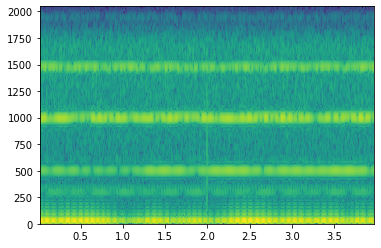

In [10]:
plt.figure()
log_sq_Sxx = np.log(np.sqrt(Sxx))
plt.pcolormesh(t, f, log_sq_Sxx)
plt.show()

In [11]:
log_sq_Sxx.shape

(257, 417)

You could either take `Sxx` or its' logarithmic value `log_sq_Sxx`

## Get Dataframe with Spectrograms

In [12]:
df['Sxx'] = [spectrogram_from_file_id(file_id) for file_id in df['id']]

In [13]:
df['Sxx_log_sq'] = df['Sxx'].apply(lambda x: np.log(np.sqrt(x)))

In [14]:
df.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label,label_name,label_text,Sxx,Sxx_log_sq
0,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,16,Scattered_Light,16_Scattered_Light,"[[2.6736488959016263e-44, 6.312238229022627e-4...","[[-50.165149962316505, -48.58433433683601, -48..."
1,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,16,Scattered_Light,16_Scattered_Light,"[[3.433352713146278e-49, 1.7778889565684834e-4...","[[-55.79656615277549, -49.217866158863025, -48..."
2,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,16,Scattered_Light,16_Scattered_Light,"[[1.5914731607978794e-40, 3.0506386746347226e-...","[[-45.81937180812792, -46.64531892126921, -47...."
3,1.133676e+09,32.246,28.532,3262.662,2.891,6512.085938,0Ted9bxWAG,H1,16,Scattered_Light,16_Scattered_Light,"[[3.4586011606159855e-44, 8.177667182606772e-4...","[[-50.036439936627225, -48.45487603715141, -47..."
4,1.136398e+09,137.711,26.100,1945.456,0.039,3760.898682,ysSzykoKTh,H1,15,Repeating_Blips,15_Repeating_Blips,"[[7.622217270374716e-42, 1.0820963587412398e-4...","[[-47.3387532990069, -47.16354429007946, -46.1..."


## Min-Max Scaling

In [15]:
warnings.simplefilter("error", "RuntimeWarning")

error_spectrograms =[]
for ii in range(df.shape[0]):
    try:
        preprocessing.minmax_scale(df['Sxx_log_sq'][ii])
    except:
        error_spectrograms.append(ii)

In [16]:
error_spectrograms

[1611, 2428, 2639, 2793, 3265]

In [18]:
df.drop(index=error_spectrograms, inplace=True)

In [19]:
df.shape

(4158, 13)

In [20]:
df['Sxx_log_sq_min_max'] = df['Sxx_log_sq'].apply(preprocessing.minmax_scale)

In [21]:
warnings.resetwarnings()

## Reshape to tensor for NN

In [22]:
df['Sxx_log_sq_min_max'][0].shape

(257, 417)

In [23]:
rescaled_data = np.reshape(np.rollaxis(np.dstack(df['Sxx_log_sq_min_max']), -1),
                           (df.shape[0], df['Sxx_log_sq_min_max'][0].shape[0], df['Sxx_log_sq_min_max'][0].shape[1], 1))

In [24]:
rescaled_data.shape

(4158, 257, 417, 1)

## Convert labels to Targets

In [25]:
Y = df['label']
Y_count_labels = len(set(Y))

In [26]:
# Shuffle data
ind = np.random.permutation(rescaled_data.shape[0])
rescaled_data = np.take(rescaled_data, ind, axis=0)
Y = np.take(Y, ind)

In [27]:
# Convert labels into one hot encoding
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
targets = onehot_encoder.fit_transform(Y.values.reshape(-1,1))

# Train-Test Split

In [29]:
# Split the data for training and validation
X_train, X_test, y_train, y_test = train_test_split(rescaled_data, targets, test_size=0.2, random_state=5)

In [30]:
print('X_train : {}'.format(X_train.shape))
print('Y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('Y_test: {}'.format(y_test.shape))

X_train : (3326, 257, 417, 1)
Y_train: (3326, 20)
X_test: (832, 257, 417, 1)
Y_test: (832, 20)


# 2D modelling
## Data architecture

**Important note!** Keras can work either with Tensorflow background or Theano. They differ in one crucial aspect - shape of the data.

Tensorflow requires the data to be stored in the following way (for 1D CNN):

- n_samples, n_features, n_channels

Whereas Theano requires:

- n_samples, n_channels, n_features

Channel in case of 2D CNN denotes to amount of colors on the image but in case of 1D it can be used to express one feature based on two datasets.

Make sure that the shape of the data is correct with respect to the Tensorflow.

In [31]:
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(3,3), activation="relu", input_shape=(X_train.shape[1], X_train.shape[2],1)))
model.add(MaxPool2D((2,2)))
#model.add(SpatialDropout1D(0.2))

model.add(Conv2D(filters=20, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D((2,2)))
#model.add(Dropout(0.2))

# Flatten your convolutional part to fit the dense part of the model
model.add(Flatten())

model.add(Dense(200, activation="relu"))
model.add(Dense(Y_count_labels, activation="softmax"))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 415, 40)      400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 207, 40)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 205, 20)      7220      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 102, 20)       0         
_________________________________________________________________
flatten (Flatten)            (None, 126480)            0         
_________________________________________________________________
dense (Dense)                (None, 200)               25296200  
_________________________________________________________________
dense_1 (Dense)              (None, 20)                4

## Callback functions

Callback functions, as the name suggests, are type of functions that are called by particular part of your code the moment it executes and process the data. In the following case I created the simple class than can be used to plot the value of loss function and accuracy during the training/validation of the model.

It will be called by `fit` method of `Sequential` object in order to train the model.

In [33]:
# real time plotting
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accuracies.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.accuracies, label="accuracy")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.val_accuracies, label="val_accuracy")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show();
        
plot_losses = PlotLosses()

## Modelling

In [37]:
import collections

try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

In [38]:
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=["acc"])

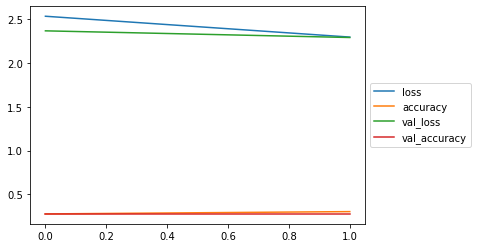

3326/3326 [==============================] - 151s 45ms/sample - loss: 2.2965 - acc: 0.3019 - val_loss: 2.2916 - val_acc: 0.2764


In [39]:
model.fit(X_train, y_train,
          epochs=2,
          batch_size=100,
          validation_data=(X_test, y_test),
          callbacks=[plot_losses])

## Evaluate

In [40]:
y_predicted = model.predict(X_test)

/Users/christopher.zerafa/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py:364: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(inputs, collections.Sequence):


In [68]:
cms = confusion_matrix(y_test.argmax(1), y_predicted.argmax(1))
cms

array([[  0,   0,   4,   0,   0,   0,   0,   0,   0,   7,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 230,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  62,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  95,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  48,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  69,   0,   0,   0,   0,   0,   0,   0,   0,  

In [42]:
test_score = np.trace(cms) / np.sum(cms)

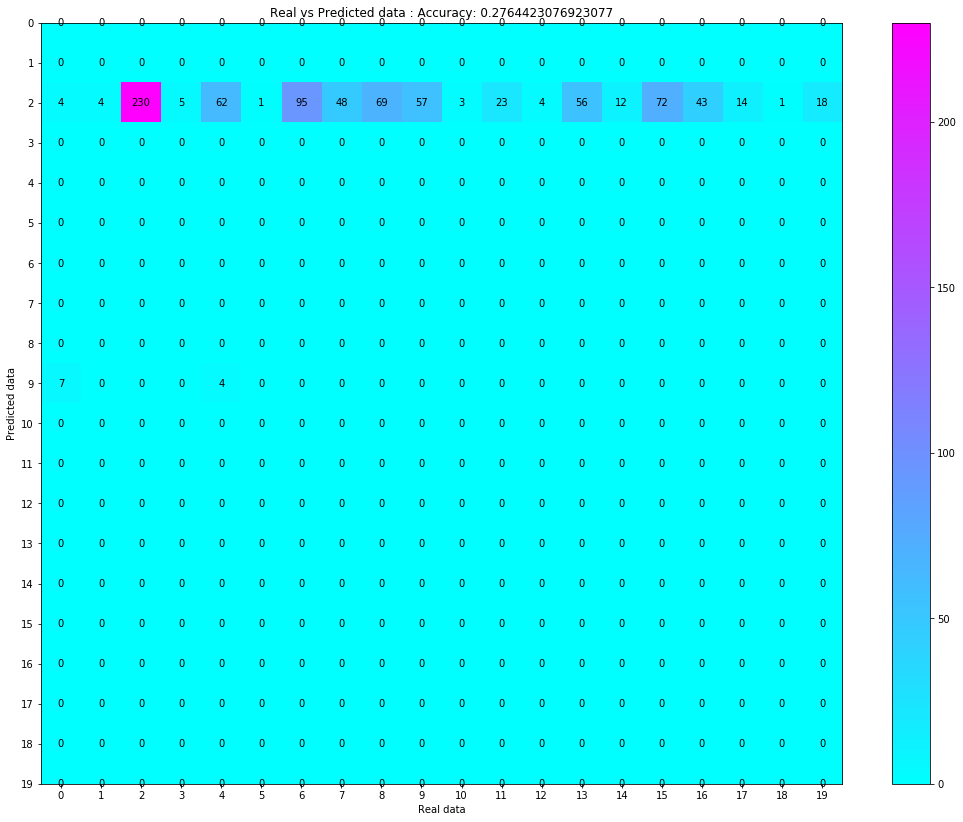

In [72]:
fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(cms), interpolation="nearest", cmap="cool")
rows = cms.shape[0]
cols = cms.shape[1]
for x in range(0, rows):
    for y in range(0, cols):
        value = int(cms[x, y])
        ax.text(x, y, value, color="black", ha="center", va="center")
plt.title("Real vs Predicted data : Accuracy: {}".format(test_score))
plt.colorbar(im)

classes_values = range(Y_count_labels)
classes_labels = [str(x) for x in range(Y_count_labels)]

plt.xticks(classes_values, classes_labels)
plt.yticks(classes_values, classes_labels)
plt.xlabel("Real data")
plt.ylabel("Predicted data")
plt.show()